PARAPHRASE DETECTION MODEL : This model helps us to find whether 2 sentences are similiar to each other or not.

Technology Used:

1.   Hugging Face Transformer : Distillbert
1.   Language : Python
2.   Library : PyTorch
4.   GPU Used: Google Colab

In [1]:
!pip install transformers

     |████████████████████████████████| 1.9MB 10.7MB/s 
     |████████████████████████████████| 3.2MB 33.4MB/s 
     |████████████████████████████████| 890kB 37.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=a2f67dfd531c8de703d02be9b07473631f43876067810b1e3ce16a8b09fe600a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# Importing Libraries

import torch
import torch.nn as nn

import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import transformers
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup

**Setting the device for model **

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
# Loading Data

DATAFOLDER = '/content/drive/MyDrive/MRPC/'               # set data path accordingly

test_df = pd.read_csv(DATAFOLDER+"msr_paraphrase_test.txt", delimiter = "\t")
train_df = pd.read_csv(DATAFOLDER+"msr_paraphrase_train.txt", delimiter = "\t")

In [11]:
# View of Data
train_df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


In [12]:
# Backup Files for original Data

train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [13]:
# Dropping Columns

drop_col_names = ["#1 ID", "#2 ID"]
train_df.drop(drop_col_names, axis = 1, inplace= True)
test_df.drop(drop_col_names, axis = 1, inplace= True)

In [14]:
# Renaming columns
rename_columns = {'Quality':'Label', '#1 String':'Original_Sentence', '#2 String':'Paraphrase_Sentence'}
train_df.rename(columns = rename_columns, inplace = True)
test_df.rename(columns = rename_columns, inplace = True)

In [15]:
# Train Data looks like below after drop and renaming the columns
train_df.head()

,Label,Original_Sentence,Paraphrase_Sentence
0,1,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


In [16]:
# Seeding for numpy and torch
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data analysis

In [19]:
# checking for null

print(test_df.isnull().sum())
train_df.isnull().sum()

Label                  0
Original_Sentence      0
Paraphrase_Sentence    0
dtype: int64


Label                  0
Original_Sentence      0
Paraphrase_Sentence    0
dtype: int64

### Draw graph which shows number of words in both questions.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


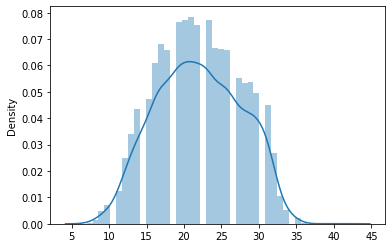

In [20]:
train_sentences_lens = train_df['Original_Sentence'].apply(lambda x: len(x.split(' '))).tolist()
train_sentences_lens.extend(train_df['Paraphrase_Sentence'].apply(lambda x: len(x.split(' '))).tolist())
sns.distplot(train_sentences_lens)

As we see from the graph, the number of cases where words counts greater than 40 is too small.

In [21]:
MAX_LEN = 40          # Based on above graph setting max_length

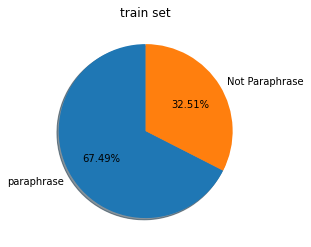

In [22]:
# Getting the distribution of class in pie chart
def pie_chart(similar_questions_num, different_questions_num, set_type):
    labels = 'paraphrase', 'Not Paraphrase'
    sizes = [similar_questions_num, different_questions_num]

    fig1, ax1 = plt.subplots()
    ax1.set_title(set_type)
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)

    plt.show()

similar_samples_num = sum(train_df['Label'].values)
pie_chart(similar_samples_num, len(train_df['Label']) - similar_samples_num, 'train set')

# Dataset Preparation

In [23]:
DISTILED_BERT_VERSION = "distilbert-base-uncased"
POOLED_OUTPUT_DIM = 768                  ## output dimesion of distledbert

In [24]:
# Loading the tokenizer of pretrained bert model

tokenizer = DistilBertTokenizer.from_pretrained(DISTILED_BERT_VERSION)

In [25]:
# split data to train and validation sets

train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [26]:
class DistilledBertDataSet:
    def __init__(self, first_questions, second_questions, targets, tokenizer):
        self.first_questions = first_questions
        self.second_questions = second_questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(first_questions)
        
    def __len__(self):
        return self.length

    def __getitem__(self, item):
        first_question = str(self.first_questions[item])
        second_question = str(self.second_questions[item])

        # removes extra white spaces from questions
        first_question = " ".join(first_question.split())
        second_question = " ".join(second_question.split())
        
        ### [CLS] question1 [SEP] questions2 [SEP] ... [PAD]
        # convert sentence to sequence
        inputs = self.tokenizer.encode_plus(
            first_question,
            second_question,
            add_special_tokens=True,
            padding='max_length',
            max_length=2 * MAX_LEN + 3, # max length of 2 questions and 3 special tokens
            truncation=True,
        )
        
        # converting sequence to tensors
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            # "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            # "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }
        

In [27]:
# creates dataset and returns dataloader of it
def get_data_loader(dataVal, targets, batch_size, shuffle, tokenizer):
    dataset = DistilledBertDataSet(
        dataVal["Original_Sentence"].values,
        dataVal["Paraphrase_Sentence"].values,
        targets=targets,
        tokenizer=tokenizer
    )
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )
    
    return data_loader

In [28]:
# training batch size we gonna use throughout this notebook.
BS = 64

In [29]:
# create data loaders of training and validation data.
train_data_loader = get_data_loader(
    train_df,
    targets=train_df["Label"].values,
    batch_size=BS,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    val_df,
    targets=val_df["Label"].values,
    batch_size=4 * BS,
    shuffle=True,
    tokenizer=tokenizer
)

# Model

In [30]:
class DistilBertModel(nn.Module):
    def __init__(self, bert_path):
        super(DistilBertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.DistilBertModel.from_pretrained(self.bert_path, output_hidden_states=True)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1)

    def forward(self, ids):
        distilbert_output = self.bert(input_ids = ids)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]

        # sys.exit("juuu....")
        # # add dropout to prevent overfitting.
        # pooled_tensor_val = torch.tensor(pooled)
        pooled = self.dropout(pooled_output) 
        return self.out(pooled)

model = DistilBertModel(DISTILED_BERT_VERSION).to(device)

# Training

In [31]:
# loss function is simple binary cross entropy loss
# need sigmoid to put probabilities in [0,1] interval
def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)

In [32]:
def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            # mask = batch["mask"].to(device, dtype=torch.long)
            # token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
            # do forward pass, will save intermediate computations of the graph for later backprop use.
            outputs = model(ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            # running backprop.
            loss.backward()
            
            # doing gradient descent step.
            optimizer.step()
            
            # we are logging current loss/perplexity in every 100 iteration
            if it % 10 == 0:
                print('| Iter', it, '| Avg Train Loss', total_loss / 100)
                total_loss = 0

            it += 1
        

In [33]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 10
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

In [34]:
run(model, train_df, device, train_data_loader, val_data_loader)

Epoch:  1
| Iter 10 | Avg Train Loss 0.06657698392868042
| Iter 20 | Avg Train Loss 0.062257171869277955
| Iter 30 | Avg Train Loss 0.061020163893699644
| Iter 40 | Avg Train Loss 0.06339754939079284
| Iter 50 | Avg Train Loss 0.058649610877037045
Epoch:  2
| Iter 60 | Avg Train Loss 0.0620017147064209
| Iter 70 | Avg Train Loss 0.056859554052352906
| Iter 80 | Avg Train Loss 0.05879280924797058
| Iter 90 | Avg Train Loss 0.05760066896677017
| Iter 100 | Avg Train Loss 0.05513323336839676
Epoch:  3
| Iter 110 | Avg Train Loss 0.04811323285102844
| Iter 120 | Avg Train Loss 0.04724299967288971
| Iter 130 | Avg Train Loss 0.04428376406431198
| Iter 140 | Avg Train Loss 0.04244817435741424
| Iter 150 | Avg Train Loss 0.04038755655288696
Epoch:  4
| Iter 160 | Avg Train Loss 0.034059738516807554
| Iter 170 | Avg Train Loss 0.030877957344055174
| Iter 180 | Avg Train Loss 0.027564523071050645
| Iter 190 | Avg Train Loss 0.02419229134917259
| Iter 200 | Avg Train Loss 0.028300231546163557
Ep

In [35]:
# Saving the model
model_pickle = DATAFOLDER+"paraphrase.h5"
torch.save(model.state_dict(), model_pickle)
print("Model Saved in H5 format")

Model Saved in H5 format


# Testing

In [37]:
# this function returns probabilities for every test case.
def test(model, test_df, device):
    predictions = torch.empty(0).to(device, dtype=torch.float)
    
    test_dataset = DistilledBertDataSet(
        first_questions=test_df["Original_Sentence"].values,
        second_questions=test_df["Paraphrase_Sentence"].values,
        targets=None,
        tokenizer=tokenizer
    )
    
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=512
    )
    
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_data_loader):
            ids = batch["ids"]
            # mask = batch["mask"]
            # token_type_ids = batch["token_type_ids"]

            ids = ids.to(device, dtype=torch.long)
            # mask = mask.to(device, dtype=torch.long)
            # token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids)
            predictions = torch.cat((predictions, nn.Sigmoid()(outputs)))
    
    return predictions.cpu().numpy().squeeze()

predictions = test(model, test_df, device)

100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


In [38]:
# write down answers in is_duplicate column.
from sklearn.metrics import f1_score
max_f1_score = 0
threshold_max = 0

for i in range (50,85):
  j=i/100
  list = []
  for val in predictions:
    if val>j:
      list.append(1)
    else:
      list.append(0)
  score_F1 = f1_score(test_df['Label'],list, average='weighted')
  if score_F1 > max_f1_score:
    max_f1_score = score_F1
    threshold_max = j


In [39]:
print(f"The maximum f1 score is: {max_f1_score} with threshold value of: {threshold_max}")

The maximum f1 score is: 0.7829216947141671 with threshold value of: 0.84


In [40]:
list = []
for val in predictions:
  if val > threshold_max:
    list.append(1)
  else:
    list.append(0)
test_df['prediction'] = list

test_df.head(10)

,Label,Original_Sentence,Paraphrase_Sentence,prediction
0,1,PCCW 's chief operating officer \t Mike Butche...,Current Chief Operating Officer Mike Butcher a...,1
1,1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1
2,1,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1
3,0,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,1
4,0,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0
5,1,The settling companies would also assign their...,Under the agreement \t the settling companies ...,1
6,0,Air Commodore Quaife said the Hornets remained...,Air Commodore John Quaife said the security op...,1
7,1,A Washington County man may have the countys f...,The countys first and only human case of West ...,1
8,1,Moseley and a senior aide delivered their summ...,General Moseley and a senior aide presented th...,1
9,0,The broader Standard & Poor 's 500 Index < .SP...,The technology-laced Nasdaq Composite Index .I...,0


In [41]:
# calculating accuracy metrics
from sklearn.metrics import classification_report
print(classification_report(test_df['Label'],test_df['prediction']))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       574
           1       0.80      0.91      0.85      1139

    accuracy                           0.79      1713
   macro avg       0.78      0.74      0.75      1713
weighted avg       0.79      0.79      0.78      1713



In [42]:
print("Confusion matrix:\n", pd.crosstab(test_df['Label'],test_df['prediction']))

Confusion matrix:
 prediction    0     1
Label                
0           324   250
1           107  1032


In [43]:
test_df["Original_Sentence"][0]

"PCCW 's chief operating officer \t Mike Butcher \t and Alex Arena \t the chief financial officer \t will report directly to Mr So ."

# Evaluation

In [44]:
# prints if two questions is similar and score of confidence
def eval(model, tokenizer, original_sentence, paraphrase_sentence, device):
    inputs = tokenizer.encode_plus(
        original_sentence,
        paraphrase_sentence,
        add_special_tokens=True,
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(device, dtype=torch.long)

    with torch.no_grad():
        model.eval()
        output = model(ids=ids)
        prob = nn.Sigmoid()(output).item()

        print("questions [{}] and [{}] are {} with score {}".format(original_sentence, paraphrase_sentence, 'similar' if prob > 0.58 else 'not similar', prob))

In [45]:
# change questions to test model
original_sentence = "And because it is so far out in international water , salvage company Odyssey Marine Exploration does not have to share the wealth with coastal state governments ."
paraphrase_sentence = "It is so far out in international water that the finder Odyssey Marine Exploration , of Tampa , Fla . , does not have to share the wealth with any governments ."

eval(model, tokenizer, original_sentence, paraphrase_sentence, device)

questions [And because it is so far out in international water , salvage company Odyssey Marine Exploration does not have to share the wealth with coastal state governments .] and [It is so far out in international water that the finder Odyssey Marine Exploration , of Tampa , Fla . , does not have to share the wealth with any governments .] are similar with score 0.9997267127037048
